In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
# import keras
import cv2 as cv

## Loading Data

In [60]:
dataDir = "C:\D\College Stuff\Semester 4\Summer Internship\Parking-Spot-Detection\Resources\dataset2"
data = tf.keras.utils.image_dataset_from_directory(dataDir, batch_size=300, image_size=(49,109))

Found 4014 files belonging to 2 classes.


In [61]:
dataIterator = data.as_numpy_iterator()


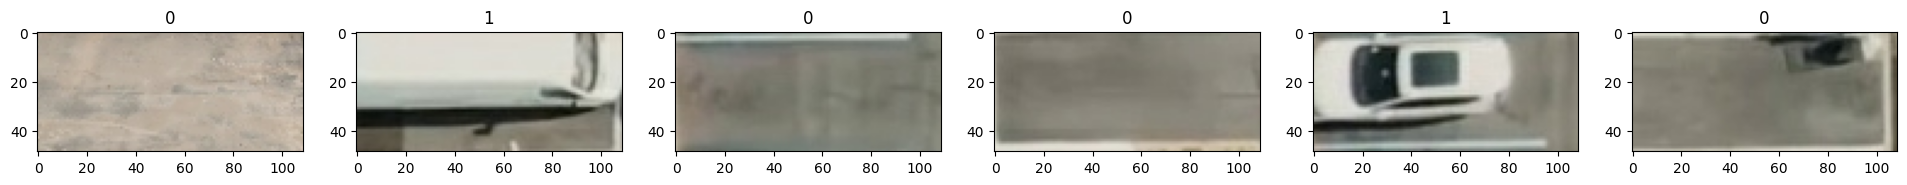

In [62]:
batch = dataIterator.next()
fig, ax = plt.subplots(ncols=6, figsize=(24,54))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [63]:
# fig, ax = plt.subplots(ncols=4, figsize=(24,54))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

## Scale Data

In [64]:
data = data.map(lambda x,y: (x/255, y))


In [65]:
# data.as_numpy_iterator().next()

## Split Data

In [66]:
trainSize = int(len(data)*.7)
valSize = int(len(data)*.2)
testSize = int(len(data)*.1)

trainSize+valSize+testSize

12

In [67]:
trainDataSet = data.take(trainSize)
valDataSet = data.skip(trainSize).take(valSize)
testDataSet = data.skip(trainSize+valSize).take(testSize)


## Building Model

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [69]:
model = Sequential()

In [70]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(49,109,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [71]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [72]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 47, 107, 16)       448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 53, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 51, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 23, 16)         4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 11, 16)       

## Training the Data

In [73]:
logdir='logs2'
tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(trainDataSet, epochs=10, validation_data=valDataSet, callbacks=[tensorboardCallback])

Epoch 1/10
9/9 [==============================] - 18s 2s/step - loss: 0.5396 - accuracy: 0.7841 - val_loss: 0.2914 - val_accuracy: 0.9983
Epoch 2/10
9/9 [==============================] - 16s 2s/step - loss: 0.1386 - accuracy: 0.9848 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.0161 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 18s 2s/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0045 - val_accuracy: 0.9983
Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 7.3934e-04 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 16s 2s/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 3.4810e-04 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 16s 2s/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/10
9/9 [==========

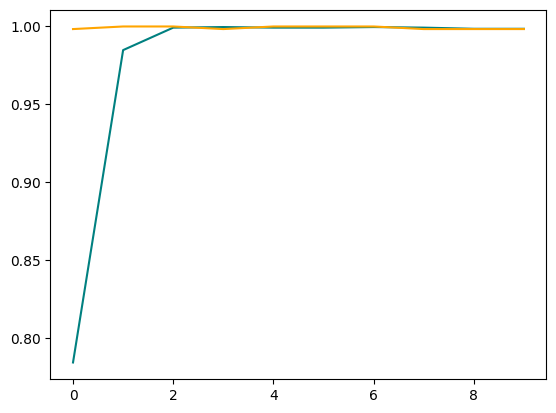

In [75]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.show()

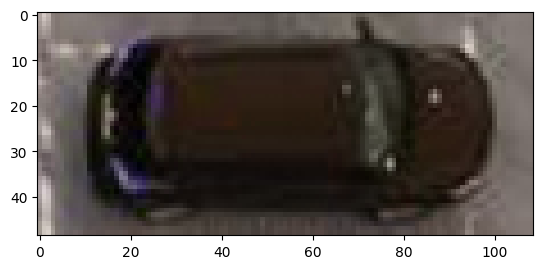

In [76]:
img = cv.imread("occTest1.jpg")
plt.imshow(img)
plt.show()

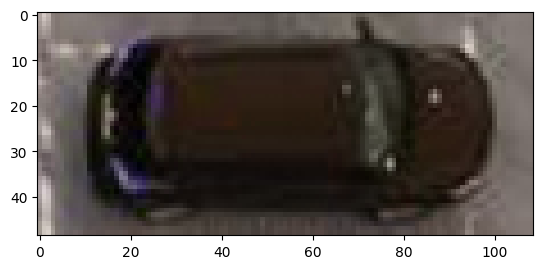

In [77]:
resize = tf.image.resize(img, (49,109))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [78]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 112ms/step


In [79]:
yhat

array([[0.9999532]], dtype=float32)

In [80]:
if yhat > 0.5: 
    print(f'Predicted class is Occupied spot.')
else:
    print(f'Predicted class is Empty spot.')

Predicted class is Occupied spot.


## Saving the model

In [81]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','parkingSpotClassifier2.h5'))

In [82]:
newModel = load_model("models/parkingSpotClassifier.h5")

In [83]:
answer =  newModel.predict(np.expand_dims(resize/255, 0))
# print(answer[0][0])

1/1 [==============================] - 0s 110ms/step


In [84]:
answer

array([[0.99990666]], dtype=float32)